In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Step 1: Load the quantized model and tokenizer
MODEL_ID = "TinyLlama-1.1B-Chat-v1.0-Smooth-GPTQ-SYM-W8A8-Dynamic-Per-Token"
MODEL_ID = "TinyLlama-1.1B-Chat-v1.0-Smooth-GPTQ-ASYM-W8A8-Dynamic-Per-Token"
# MODEL_ID = "TinyLlama-1.1B-Chat-v1.0-W8A8-Dynamic-Per-Token"
# MODEL_ID = "TinyLlama-1.1B-Chat-v1.0-W8A8-Static-Per-Token"
model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

# Step 1: Load the quantized model and tokenizer (vLLM)
# import os
# from vllm import LLM
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# model = LLM("./TinyLlama-1.1B-Chat-v1.0-W8A8-Dynamic-Per-Token")

In [3]:
from datasets import load_dataset

# Step 2: Prepare Calibration Data
NUM_CALIBRATION_SAMPLES=1
MAX_SEQUENCE_LENGTH=2048

# Load dataset.
ds = load_dataset("HuggingFaceH4/ultrachat_200k", split=f"train_sft[:{NUM_CALIBRATION_SAMPLES}]")
ds = ds.shuffle(seed=42)

# Preprocess the data into the format the model is trained with.
def preprocess(example):
    return {"text": tokenizer.apply_chat_template(example["messages"], tokenize=False,)}
ds = ds.map(preprocess)

# Tokenize the data (be careful with bos tokens - we need add_special_tokens=False since the chat_template already added it).
def tokenize(sample):
    return tokenizer(sample["text"], padding=False, max_length=MAX_SEQUENCE_LENGTH, truncation=True, add_special_tokens=False)
ds = ds.map(tokenize, remove_columns=ds.column_names)

Map: 100%|██████████| 1/1 [00:00<00:00, 70.38 examples/s]


In [4]:
for k, v in vars(model.model.layers[0].self_attn.q_proj).items():
    print(f"{k}: {v}")

# print(model.model.layers[0].self_attn.q_proj.weight_scale)

training: False
_parameters: {'bias': None, 'weight_scale': Parameter containing:
tensor([[0.0010],
        [0.0018],
        [0.0009],
        ...,
        [0.0010],
        [0.0009],
        [0.0009]], dtype=torch.bfloat16), 'weight': Parameter containing:
tensor([[  0,   0,  -6,  ...,   0,   0,  -2],
        [  0,   0,  -8,  ...,   0,   1,   1],
        [  0,   0, -16,  ...,   1,   0,  -2],
        ...,
        [  2,   0,   9,  ...,  -1,   1,  -2],
        [ -2,   0,  -6,  ...,   1,  -2,   2],
        [ -2,   0,  -6,  ...,   1,  -2,   2]], dtype=torch.int8)}
_buffers: {}
_non_persistent_buffers_set: set()
_backward_pre_hooks: OrderedDict()
_backward_hooks: OrderedDict()
_is_full_backward_hook: None
_forward_hooks: OrderedDict()
_forward_hooks_with_kwargs: OrderedDict()
_forward_hooks_always_called: OrderedDict()
_forward_pre_hooks: OrderedDict()
_forward_pre_hooks_with_kwargs: OrderedDict()
_state_dict_hooks: OrderedDict()
_state_dict_pre_hooks: OrderedDict()
_load_state_dict_pre_ho

In [5]:
import torch

layer_distributions = {}

# Define a hook function to print input and weight distributions
def collect_distribution(module, input, output):
    name = getattr(module, "_hook_name", module.__class__.__name__)
    if name not in layer_distributions:
        layer_distributions[name] = {
            "weight": module.weight.data.detach().cpu(),
            "weight_scale": module.weight_scale.detach().float().cpu(),
            "weight_int8": torch.round(module.weight.data / module.weight_scale).detach().int().cpu(),
            "inputs": [],
            "inputs_int8": [],
            # "input_scale": module.input_scale,
        }

    if isinstance(input, tuple) and len(input) > 0:
        inp = input[0]
        inp_int8 = torch.round(input[0] / module.input_scale)
        if isinstance(inp, torch.Tensor):
            layer_distributions[name]["inputs"].append(inp.detach().float().cpu())
            layer_distributions[name]["inputs_int8"].append(inp_int8.detach().int().cpu())


# Register the hook to all CompressedLinear layers
# for name, module in model.named_modules():
#     if module.__class__.__name__ == "CompressedLinear":
#         module._hook_name = name
#         module.register_forward_hook(collect_distribution)


In [6]:
# print(f'{model.model.layers[0].self_attn.q_proj.weight_scale[0].item():.10f}')
# print(f'{model.model.layers[0].self_attn.q_proj.weight.data[0, 0].item():.10f}')
# print(model.model.layers[0].self_attn.q_proj.weight.data[0, :10] / model.model.layers[0].self_attn.q_proj.weight_scale[0])
# print(model.model.layers[0].self_attn.q_proj.quantization_status)

# for name, module in model.named_modules():
#     if hasattr(module, "quantization_status"):
#         print(f"{name}: {module.quantization_status}")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Example forward pass to trigger the hook
for i, sample in enumerate(ds):
    with torch.no_grad():
        input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0).to(device)
        attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0).to(device)
        print(f"Processing sample: {i}, length: {input_ids.shape}")
        _ = model(input_ids=input_ids)

Processing sample: 0, length: torch.Size([1, 787])


In [8]:
import numpy as np
layer_distributions = {}

for name, module in model.named_modules():
    if hasattr(module, "weight") and hasattr(module, "weight_scale"):
        weight = module.weight.data.detach().cpu()
        weight_scale = module.weight_scale.detach().float().cpu()
        weight_int8 = (weight / weight_scale).detach().int().cpu().numpy().flatten()
        
        inputs = np.concatenate([
            inp.flatten().cpu().numpy()
            for inp in module.inputs
        ])
        inputs_int8 = np.concatenate([
            inp.flatten().cpu().numpy()
            for inp in module.quantized_inputs
        ])
        
        layer_distributions[name] = {
            "weight_scale": weight_scale,
            "weight_int8": weight_int8,
            "inputs": inputs,
            "inputs_scales": module.input_scales,
            "inputs_int8": inputs_int8,
        }

In [9]:
print("Zero Percentage of Weights_int8 and Inputs_int8 in Each Layer:")
for k, v in layer_distributions.items():
    weight = v["weight_int8"]
    inputs = v["inputs_int8"]
    weight_zero_percentage = (weight == 0).sum().item() / weight.size
    inputs_zero_percentage = (inputs == 0).sum().item() / inputs.size
    print(f"{k:<32} -   Weight {weight_zero_percentage:6.2%},   Input {inputs_zero_percentage:7.2%}")
    ws = v["weight_scale"].numpy().flatten()
    ws_inv = 1.0 / ws
    print(f"    Weight scale min: {ws_inv.min():.2f}, max: {ws_inv.max():.2f}, mean: {ws_inv.mean():.2f}")
    inp_scales = np.concatenate([s.numpy().flatten() for s in v["inputs_scales"] if hasattr(s, "numpy")])
    inp_scales_inv = 1.0 / inp_scales
    print(f"    Input  scale min: {inp_scales_inv.min():.2f}, max: {inp_scales_inv.max():.2f}, mean: {inp_scales_inv.mean():.2f}")

Zero Percentage of Weights_int8 and Inputs_int8 in Each Layer:
model.layers.0.self_attn.q_proj  -   Weight 55.95%,   Input  10.62%
    Weight scale min: 28.05, max: 5793.24, mean: 709.35
    Input  scale min: 68.27, max: 366.12, mean: 153.67
model.layers.0.self_attn.k_proj  -   Weight 72.78%,   Input  10.62%
    Weight scale min: 14.32, max: 1032.06, mean: 251.40
    Input  scale min: 68.27, max: 366.12, mean: 153.67
model.layers.0.self_attn.v_proj  -   Weight  5.99%,   Input  10.62%
    Weight scale min: 1409.38, max: 33420.75, mean: 18172.70
    Input  scale min: 68.27, max: 366.12, mean: 153.67
model.layers.0.self_attn.o_proj  -   Weight  2.45%,   Input  23.73%
    Weight scale min: 334.37, max: 4788.02, mean: 3181.64
    Input  scale min: 464.79, max: 3102.30, mean: 1870.86
model.layers.0.mlp.gate_proj     -   Weight  6.15%,   Input   3.20%
    Weight scale min: 85.78, max: 3102.30, mean: 997.19
    Input  scale min: 166.34, max: 478.36, mean: 297.85
model.layers.0.mlp.up_proj     

In [10]:
import numpy as np

weight = layer_distributions["model.layers.0.self_attn.q_proj"]["weight_int8"]
inputs = layer_distributions["model.layers.0.self_attn.q_proj"]["inputs"]

weight_mean = np.mean(weight)
weight_std = np.std(weight)
weight_abs_lt_10_pct = np.mean(np.abs(weight) < 10) * 100

inputs_mean = np.mean(inputs)
inputs_std = np.std(inputs)
inputs_abs_lt_10_pct = np.mean(np.abs(inputs) < 10) * 100

inputs_int8 = layer_distributions["model.layers.0.self_attn.q_proj"]["inputs_int8"]
inputs_int8_mean = np.mean(inputs_int8)
inputs_int8_std = np.std(inputs_int8)
inputs_int8_abs_lt_10_pct = np.mean(np.abs(inputs_int8) < 10) * 100

print(f"Weight Mean: {weight_mean:.4f}")
print(f"Weight Std: {weight_std:.4f}")
print(f"Weight Percentage of |value| < 10: {weight_abs_lt_10_pct:.2f}%")
print(f"Inputs Mean: {inputs_mean:.6f}")
print(f"Inputs Std: {inputs_std:.6f}")
print(f"Inputs Percentage of |value| < 10: {inputs_abs_lt_10_pct:.2f}%")
print(f"Inputs_int8 Mean: {inputs_int8_mean:.4f}")
print(f"Inputs_int8 Std: {inputs_int8_std:.4f}")
print(f"Inputs_int8 Percentage of |value| < 10: {inputs_int8_abs_lt_10_pct:.2f}%")

Weight Mean: -0.0028
Weight Std: 6.4744
Weight Percentage of |value| < 10: 97.45%
Inputs Mean: 0.000406
Inputs Std: 0.058652
Inputs Percentage of |value| < 10: 100.00%
Inputs_int8 Mean: 0.0387
Inputs_int8 Std: 9.6565
Inputs_int8 Percentage of |value| < 10: 80.97%


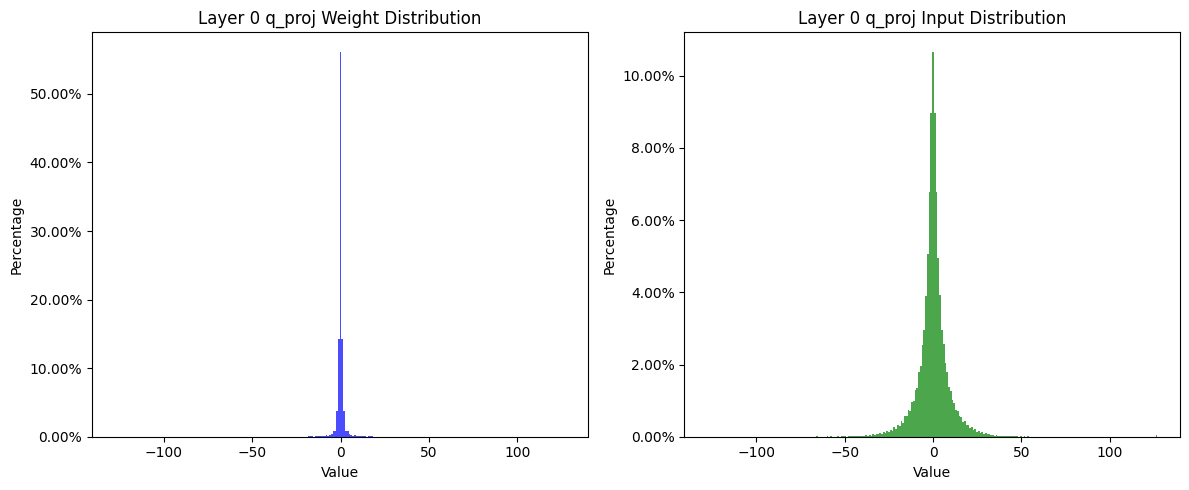

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Get the weight and input distributions for layer 0 q_proj
weight = layer_distributions["model.layers.0.self_attn.q_proj"]["weight_int8"]
inputs = layer_distributions["model.layers.0.self_attn.q_proj"]["inputs_int8"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
counts, bins, patches = plt.hist(weight, bins=256, range=(-128,127), color='blue', alpha=0.7, density=True)
plt.title("Layer 0 q_proj Weight Distribution")
plt.xlabel("Value")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.2f}%'))

plt.subplot(1, 2, 2)
counts, bins, patches = plt.hist(inputs, bins=256, color='green', alpha=0.7, density=True)
plt.title("Layer 0 q_proj Input Distribution")
plt.xlabel("Value")
plt.ylabel("Percentage")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.2f}%'))

plt.tight_layout()
plt.show()